In [13]:
import numpy as np
import matplotlib.pyplot as pl
import sbpd_func as ib
import progressbar as pb
pl.style.use('dark_background')

In [14]:
savefigs = 0

np.random.seed(6)

#dimension
n = 50

#reference measure theta
#sampled from the dirichlet distribution so that it lies in the simplex
theta = np.random.dirichlet(np.ones(n))

#penalty parameter for total variation
beta = 1

#cost matrix
cmat = np.zeros([n,n])
for i in range(n):
    for j in range(n):
        cmat[i,j] = (i - j) ** 2

#entropic regularizaiton paramter
gamma = 1

#iterations: itera is the initial run for finding the solutions, itera2 is to get lagrangian values
itera = int(10000)
itera2 = int(8 * itera / 10)

#initial points (must be in interior of domain, i.e. simplex for x and R(2n-1) for mu)
x0 = (1./n) * np.ones(n)
mu0 = np.zeros(n + (n - 1))

#Relative-smoothness constants for primal Lp and dual Ld
#Since there is no primal smooth term, Lp=0
Lp = 0
#Ld is the relative smoothness constant for the dual function h.
#it is the sum of rho_j the reference measure over epsilon, the entropic reg. parameter
Ld = 2 * theta.sum() / gamma

#operator norm of the consecutive difference (gradient) operator
nablanorm = 3.01

#set step sizes to ensure convergence accoridng to the paper
prim_size = 1. / (Lp + nablanorm)
dual_size = 1. / (Ld + nablanorm)

loopcounter = pb.progressbar(range(itera))

#argdict holds the "global" variables
argdict = {'primalsize':prim_size, 'dualsize':dual_size, 'infballrad':beta, 'theta':theta, 'xsol':x0, 'musol':mu0, 'dimension':n, 'costmatrix':cmat, 'gamma':gamma, 'lagrangian':0, 'loopcounter':loopcounter}

In [15]:
#run the algorithm once to find a good (x,mu) pair for calculating lagrangian values
#there is only one function ibpd so we run this with (x0,mu0) as our good pair (they're not good)
argdict['xsol'], argdict['musol'], throw_val, throw_val2 = ib.ibpd(itera, x0, mu0, ib.shanbolt_grad, ib.id_map, ib.exp_regularize, ib.wasserstein_dualprox, ib.zero_map, ib.wasserstein_gradh, ib.wasserstein_linop, ib.wasserstein_linopT, ib.wasserstein_lagr_x, ib.wasserstein_lagr_mu, argdict)

100% (10000 of 10000) |##################| Elapsed Time: 0:00:02 Time:  0:00:02


In [16]:
#run the algorithm with a good pair (x,mu) and collect lagrangian values along the way
#we don't need any of the outputs here except the lagrangian values
argdict['lagrangian'] = 1
argdict['loopcounter'] = pb.progressbar(range(itera2))
argdict['linopTmusol'] = ib.wasserstein_linopT(argdict['musol'], argdict)
argdict['linopxsol'] = ib.wasserstein_linop(argdict['xsol'], argdict)
argdict['hmusol'] = ib.wasserstein_h(argdict['musol'], argdict)
throwx, throwmu, erglagr_vals, pwlagr_vals = ib.ibpd(itera2, x0, mu0, ib.shanbolt_grad, ib.id_map, ib.exp_regularize, ib.wasserstein_dualprox, ib.zero_map, ib.wasserstein_gradh, ib.wasserstein_linop, ib.wasserstein_linopT, ib.wasserstein_lagr_x, ib.wasserstein_lagr_mu, argdict)

100% (8000 of 8000) |####################| Elapsed Time: 0:00:04 Time:  0:00:04


In [17]:
#calculate the constant for the ergodic rate using the primal entropy, dual entropy, and linear form
CONST = (1. / argdict['primalsize']) * ib.kldiv(argdict['xsol'], x0) + (1. / argdict['dualsize']) * 0.5 * (np.linalg.norm(argdict['musol'] - mu0) ** 2) - np.dot(ib.wasserstein_linop(argdict['xsol'] - x0), argdict['musol'] - mu0)

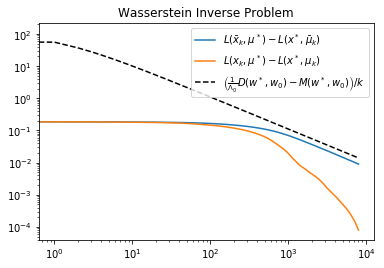

In [18]:
#plot the lagrangian values
pl.plot(erglagr_vals, label=r'$L(\bar{x}_k,\mu^*) - L(x^*, \bar{\mu}_k)$')
pl.plot(pwlagr_vals, label=r'$L(x_k,\mu^*) - L(x^*, \mu_k)$')
pl.plot(CONST / ((np.array(range(itera2)) + 1)), 'k--', label=r'$\left(\frac{1}{\Lambda_0}D(w^*,w_0)-M(w^*,w_0)\right)/k$')
#pl.xlim((1e2, itera2))
#pl.ylim((1e-3, 1e1))
pl.xscale('log')
pl.yscale('log')
pl.title('Wasserstein Inverse Problem')
pl.legend(loc='upper right')
if savefigs == 1:
    pl.savefig('Wasserstein.eps', bbox_inches='tight')
pl.show()

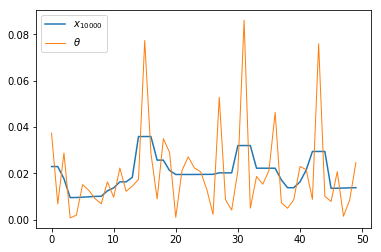

In [24]:
#plot the initial primal variable, the final primal variable, and the data
pl.plot(argdict['xsol'], label=r'$x_{'+str(itera)+'}$')
pl.plot(theta, linewidth='1', label=r'$\theta$')
pl.legend()
pl.show()

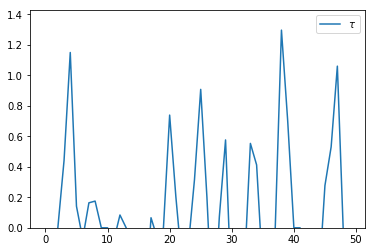

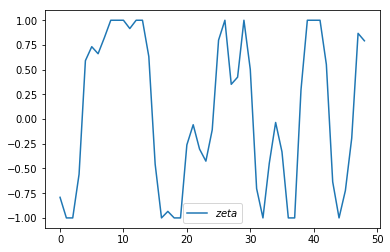

In [21]:
#plot the dual variables
#remember that the variable mu is actually
#tau and zeta lifted to a product space
tau = argdict['musol'][0:n]
zeta = argdict['musol'][n:]
pl.plot(tau, label=r'$\tau$')
pl.ylim([0, 1.1 * tau.max()])
pl.legend()
pl.show()
pl.plot(zeta, label=r'$zeta$')
pl.legend()
pl.show()